In [8]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from dsn.util.systems import LowRankRNN
from dsn.train_dsn import train_dsn
from dsn.util.plot_util import assess_constraints, pairplot
import warnings
import scipy
import time
warnings.filterwarnings("ignore")


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
# set fixed params
fixed_params = {'MI':0.0, \
                'Sm':1.0, \
                'Sn':1.0, \
                'SmI':0.0, \
                'Sperp':0.0}

# set behavior
behavior_type = 'ND'
means = np.array([1.0, 0.0]);
variances = np.array([0.01, 0.0]);
behavior = {'type':behavior_type, \
            'means':means, \
            'variances':variances}

# set model options
model_opts = {'rank':1, 'input_type':'input'}

solve_its = 25
solve_eps = 0.8

system = LowRankRNN(fixed_params, behavior, model_opts=model_opts, \
                    solve_its=solve_its, solve_eps=solve_eps)
print(system.free_params)
print(system.T_x_labels)

['g', 'Mm', 'Mn']
['$\\kappa_{HI}  -\\kappa_{LO}$', '$(\\kappa_{HI}  -\\kappa_{LO})^2$']


In [10]:
sample_str = 'grid';
num_params = 3
if (sample_str == 'grid'):
    # create test parameter grid
    bound = 3.0
    start = 0.0;
    stop = bound;
    res = 0.25
    eps = .001*res;
    vals = np.arange(start, stop+eps, res);
    num_pts = vals.shape[0];

    total_pts = num_pts**num_params;
    params = np.zeros((total_pts,num_params));
    ind = 0;
    for i in range(num_pts):
        g = vals[i];
        for j in range(num_pts):
            Mm = vals[j];
            for k in range(num_pts):
                Mn = vals[k];
                params[ind, :] = np.array([g, Mm, Mn])
                ind += 1;
                        

In [11]:
Z = tf.placeholder(dtype=tf.float64, shape=(1,None,num_params))
_Z = np.expand_dims(params, 0)
T_x = system.compute_suff_stats(Z)

In [12]:
sess = tf.Session()

In [13]:
_T_x = sess.run(T_x, {Z:_Z})

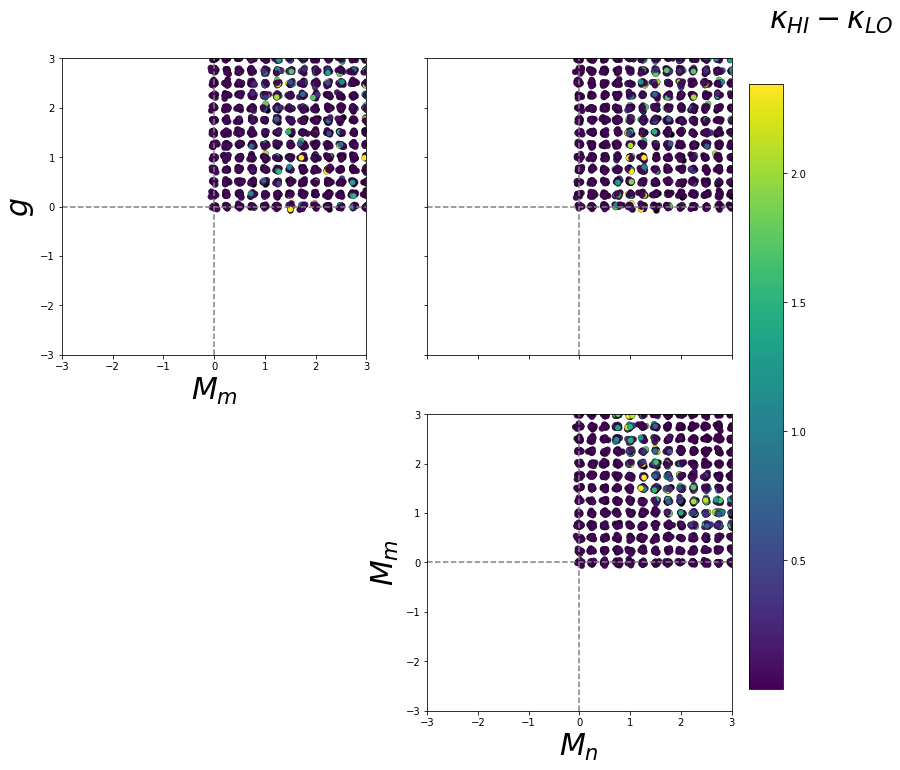

In [14]:
pfname = 'images/LRRNN_explore_z.png'
axlim = 3
xlims = [-axlim, axlim]
ylims = [-axlim, axlim]

jitter = np.random.normal(0.0, 0.025, _Z.shape)
_Z_plot = (_Z + jitter)

fig = pairplot(_Z_plot[0], range(3), system.z_labels, origin=True, \
                   c=_T_x[0,:,1], c_label=system.T_x_labels[0], cmap=None, \
                   xlims=xlims, ylims=ylims, fontsize=30, \
                   figsize=(12,12), pfname=pfname)



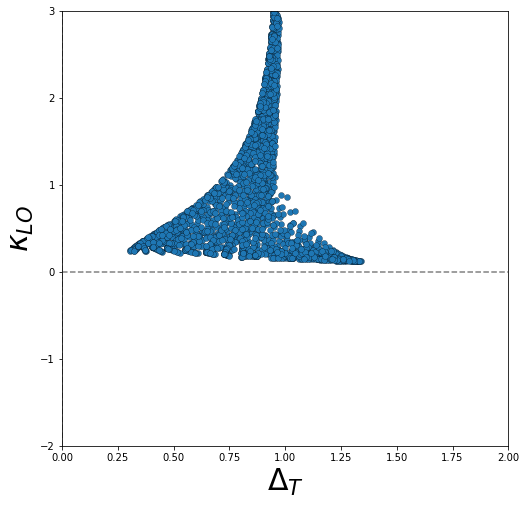

In [26]:
pfname = 'images/LRRNN_explore_T_x.png'
axlim = 2
xlims = [0, axlim]
ylims = [-axlim, axlim+1]

fig = pairplot(_T_x[0], range(2), system.T_x_labels, origin=True, \
                   c=None, c_label=None, cmap=None, \
                   xlims=xlims, ylims=ylims, fontsize=30, \
                   figsize=(8,8), pfname=pfname)



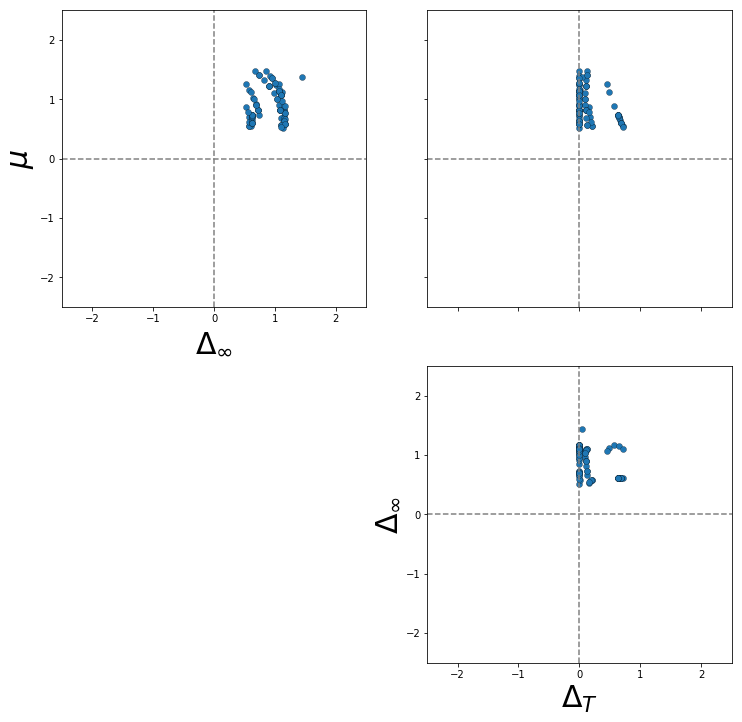

In [11]:
pfname = 'images/LRRNN_grid_search_T_x_thresh.png'

axlim = 2.5
xlims = [-axlim, axlim]
ylims = [-axlim, axlim]

delta_T_inc = np.logical_and(0.0 < _T_x[0,:,2], _T_x[0,:,2] < 1.0);
delta_inf_inc = np.logical_and(0.5 < _T_x[0,:,1], _T_x[0,:,1] < 1.5);
mu_inc = np.logical_and(0.5 < _T_x[0,:,0], _T_x[0,:,0] < 1.5);
delta_inf_inc_delta_T_inc = np.logical_and(delta_T_inc, delta_inf_inc);
inds =  np.logical_and(delta_inf_inc_delta_T_inc, mu_inc);

fig = pairplot(_T_x[0, inds, :], range(3), system.T_x_labels, origin=True, \
                   c=None, c_label=None, cmap=None, \
                   xlims=xlims, ylims=ylims, fontsize=30, \
                   figsize=(12,12), pfname=pfname)

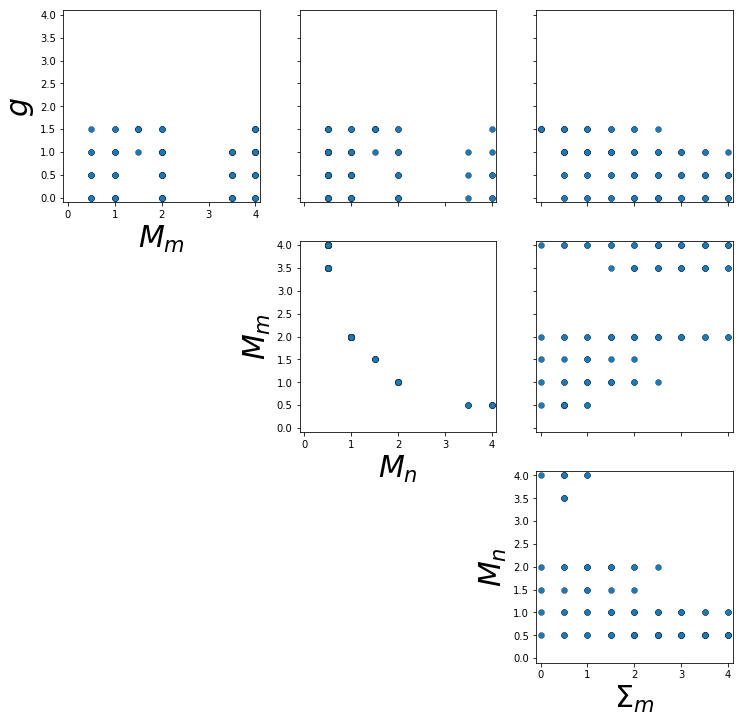

In [12]:
pfname = 'images/LRRNN_grid_search_Z_tresh.png'
_Z_filt = _Z[0,inds, :]

fig = pairplot(_Z_filt, range(4), system.z_labels, origin=False, \
               c=None, c_label=None, cmap=None, \
               xlims=lims, ylims=lims, fontsize=30, \
               figsize=(12,12), pfname=pfname)

85
(1, 6561, 4)
0.9160783645270059 0.27204162404702265


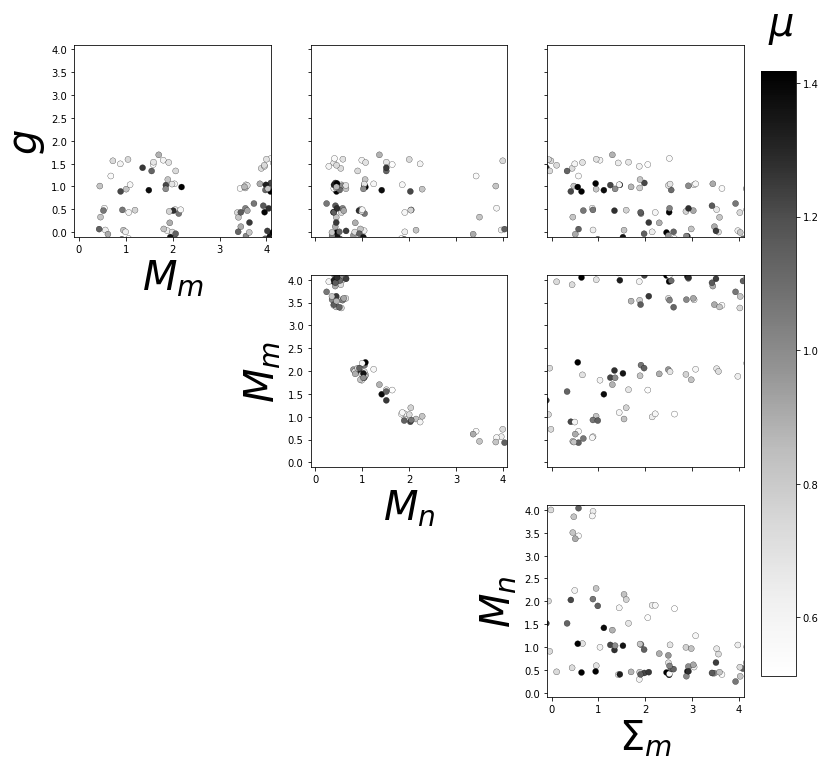

0.9046139795849473 0.2341953991857025


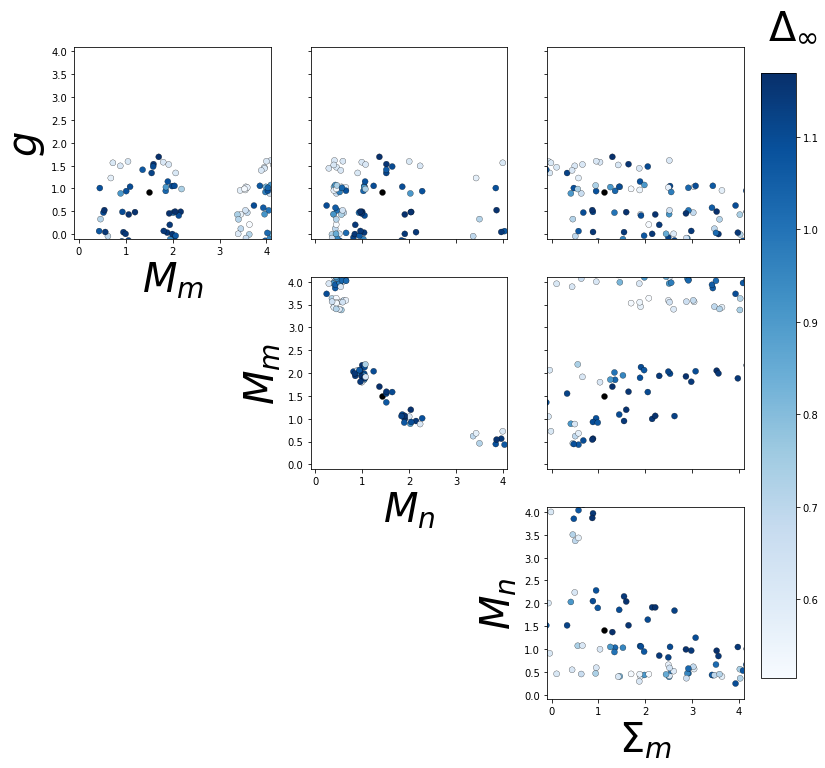

0.16339077951957282 0.24353023746887204


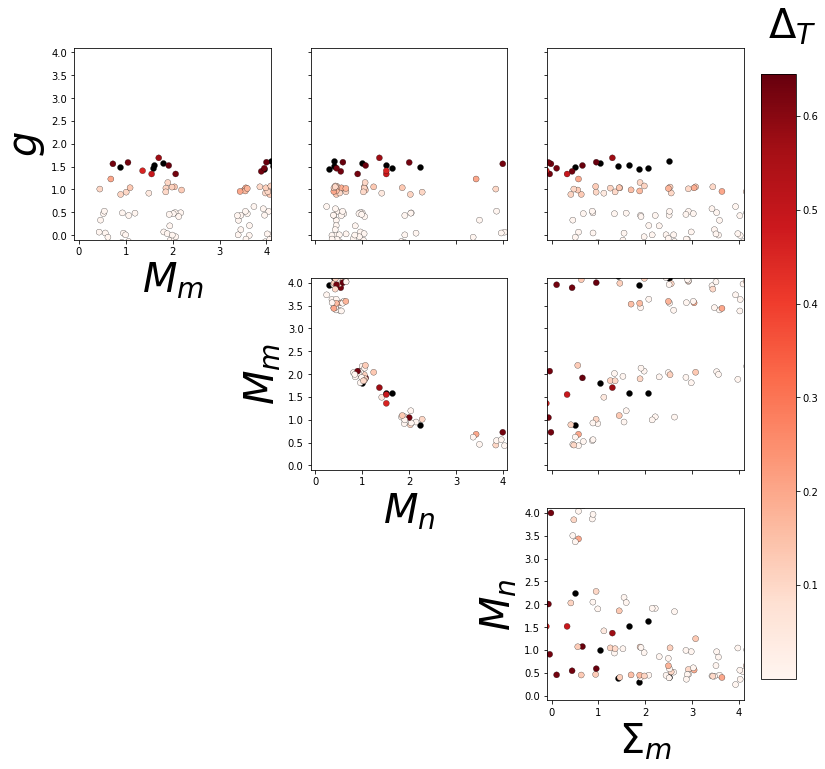

In [13]:
pfname = 'images/Z_S_inc_V_same.png'

mu_inc = np.logical_and(0.5 < _T_x[0,:,0], _T_x[0,:,0] < 1.5);
inds =  np.logical_and(delta_inf_inc_delta_T_inc, mu_inc);

lims = [-.1, 4.1]
print(np.sum(inds))
print(_Z.shape)
_Z_filt = _Z[0,inds, :]
jitter = np.random.normal(0.0, 0.1, _Z_filt.shape)
_Z_filt = _Z_filt + jitter
for color_ind in range(3):
    fig = pairplot(_Z_filt, range(4), system.z_labels, origin=False, \
                       c=_T_x[0,inds,color_ind], c_label=system.T_x_labels[color_ind], cmap=cmaps[color_ind], \
                       xlims=lims, ylims=lims, fontsize=40, \
                       figsize=(12,12), pfname=pfname)